In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import warnings
warnings.filterwarnings('ignore')

import sys
import os
from typing import List, Dict, Any
# Add the parent directory to sys.path
notebook_dir = os.path.abspath('')
project_dir = os.path.dirname(notebook_dir)
sys.path.append(project_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import statsmodels.api as sm


from src.data_processing import prepare_data, load_data
from src.modeling import BayesianModel

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from src.data_processing import prepare_data

In [2]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()

# Determine environment and data path
environment = os.getenv('ENVIRONMENT', 'local')
data_path = os.getenv('LOCAL_DATA_PATH') if environment == 'local' else os.getenv('CLOUD_DATA_PATH')
processed_data_path = os.getenv('LOCAL_DATA_PATH_PROCESSED') if environment == 'local' else os.getenv('CLOUD_DATA_PATH')

# File paths
behavioral_path = os.path.join(data_path, 'connectome_behavioral.csv')
behavioral_path_processed = os.path.join(processed_data_path, 'connectome_behavioral.csv')


hcp_path = os.path.join(data_path, 'hcp_freesurfer.csv')
hcp_path_processed = os.path.join(processed_data_path, 'hcp_freesurfer.csv')

In [3]:
behavioral_features = [
    'Subject', 'Age', 'Gender', 'CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'MMSE_Score',
    'NEOFAC_O', 'NEOFAC_C', 'ProcSpeed_Unadj', 'CardSort_Unadj', 'PicVocab_Unadj', 'ReadEng_Unadj'
]

hcp_features = [
    'Subject', 'FS_TotCort_GM_Vol', 'FS_SubCort_GM_Vol', 'FS_Total_GM_Vol', 'FS_Tot_WM_Vol', 'FS_BrainStem_Vol',
    'FS_L_Hippo_Vol', 'FS_R_Hippo_Vol', 'FS_L_Amygdala_Vol', 'FS_R_Amygdala_Vol',
    'FS_L_Caudate_Vol', 'FS_R_Caudate_Vol', 'FS_L_Putamen_Vol', 'FS_R_Putamen_Vol',
]

categorical_columns = ['Age', 'Gender']

prior_edges = [
    ('Age', 'CogFluidComp_Unadj'),
    ('Age', 'CogCrystalComp_Unadj'),
    ('Age', 'MMSE_Score'),
    ('Gender', 'CogFluidComp_Unadj'),
    ('Gender', 'CogCrystalComp_Unadj'),
    ('MMSE_Score', 'CogFluidComp_Unadj'),
    ('MMSE_Score', 'CogCrystalComp_Unadj'),
    ('FS_Total_GM_Vol', 'CogFluidComp_Unadj'),
    ('FS_Total_GM_Vol', 'CogCrystalComp_Unadj'),
    ('FS_Tot_WM_Vol', 'CogFluidComp_Unadj'),
    ('FS_Tot_WM_Vol', 'CogCrystalComp_Unadj'),
    ('FS_L_Hippo_Vol', 'CogFluidComp_Unadj'),
    ('FS_R_Hippo_Vol', 'CogFluidComp_Unadj'),
    ('FS_L_Amygdala_Vol', 'NEOFAC_O'),
    ('FS_R_Amygdala_Vol', 'NEOFAC_O'),
    ('NEOFAC_O', 'CogCrystalComp_Unadj'),
    ('NEOFAC_C', 'CogFluidComp_Unadj'),
    ('FS_L_Hippo_Vol', 'NEOFAC_O'),
    ('FS_R_Hippo_Vol', 'NEOFAC_O'),
    ('ProcSpeed_Unadj', 'CogFluidComp_Unadj'),
    ('CardSort_Unadj', 'CogFluidComp_Unadj'),
    # New edges emphasizing ProcSpeed_Unadj and CardSort_Unadj
    ('ProcSpeed_Unadj', 'CogCrystalComp_Unadj'),
    ('CardSort_Unadj', 'CogCrystalComp_Unadj'),
    ('ProcSpeed_Unadj', 'MMSE_Score'),
    ('CardSort_Unadj', 'MMSE_Score'),
    ('ProcSpeed_Unadj', 'NEOFAC_O'),
    ('CardSort_Unadj', 'NEOFAC_C'),
]

In [4]:
def map_age_to_category(age_str):
    # Define age bins and corresponding ordinal categories
    bins = ['22-25', '26-30', '31-35', '36+']
    categories = [1, 2, 3, 4]  # Assigning ordinal values to age ranges
    
    if pd.isna(age_str):
        return np.nan
    age_str = age_str.strip()
    
    if age_str in bins:
        return categories[bins.index(age_str)]
    else:
        return np.nan

def process_age_gender(data: pd.DataFrame) -> pd.DataFrame:
    if 'Age' in data.columns and data['Age'].dtype == 'object':
        data['Age'] = data['Age'].apply(map_age_to_category)
    return data

# Load your data
behavioral_data = pd.read_csv(behavioral_path)
hcp_data = pd.read_csv(hcp_path)
# Process Age column
behavioral_data = process_age_gender(behavioral_data)

# You can now save the processed data back to CSV if needed or pass it directly to prepare_data
behavioral_data.to_csv('/Users/macbookair/Documents/NeuroBayesianModel/data/processed/connectome_behavioral.csv', index=False)

In [5]:
# Now call prepare_data
data, categorical_columns, categories = prepare_data(
    behavioral_path=behavioral_path_processed,
    hcp_path=hcp_path_processed,
    behavioral_features=behavioral_features,
    hcp_features=hcp_features,
    categorical_columns=categorical_columns,
    index='Subject'
)

model = BayesianModel(method='nsl', max_parents=3, iterations=250, categorical_columns=categorical_columns)

# Fit the model
model.fit(data, prior_edges=prior_edges)

Created 24 nodes in total
Fitted CategoricalNode Age
Fitted CategoricalNode Gender
Initialized Inference with 24 nodes


In [6]:
if data['Age'].dtype == 'int8' or data['Gender'].dtype == 'int8':
    print("changing types")
    data['Age'] = data['Age'].astype('category')
    data['Gender'] = data['Gender'].astype('category')

changing types


In [7]:
print("\nFitting a categorical node (Age):")
age_node = model.network.nodes.get('Age')
if age_node:
    age_data = data['Age']
    age_node.fit(age_data)
    print("Age node distribution:", age_node.distribution)
else:
    print("Age node not found")

print("\nFitting a continuous node (CogFluidComp_Unadj):")
cog_fluid_node = model.network.nodes.get('CogFluidComp_Unadj')
if cog_fluid_node:
    cog_fluid_data = data['CogFluidComp_Unadj']
    parent_names = model.network.get_parents('CogFluidComp_Unadj')
    parent_data = data[parent_names] if parent_names else None
    cog_fluid_node.fit(cog_fluid_data, parent_data)
    print("CogFluidComp_Unadj node distribution:", cog_fluid_node.distribution)
else:
    print("CogFluidComp_Unadj node not found")

print("\nTrying to compute sensitivity:")
try:
    sensitivity = model.network.inference.compute_sensitivity("CogFluidComp_Unadj")
    print("Sensitivity:", sensitivity)
except Exception as e:
    print(f"Error computing sensitivity: {str(e)}")



Fitting a categorical node (Age):
Fitted CategoricalNode Age
Age node distribution: {1: 0.4366576819407008, 2: 0.344115004492363, 0: 0.20754716981132076, 3: 0.011680143755615454}

Fitting a continuous node (CogFluidComp_Unadj):
CogFluidComp_Unadj node distribution: {'intercept': 0.10237100759953044, 'beta': Age               -0.033835
MMSE_Score         0.072092
FS_L_Hippo_Vol     0.038270
FS_Tot_WM_Vol     -0.061504
NEOFAC_C          -0.026988
FS_Total_GM_Vol    0.157808
FS_R_Hippo_Vol    -0.028940
Gender            -0.138575
ProcSpeed_Unadj    0.512605
CardSort_Unadj     0.445685
dtype: float64, 'std': 0.5390385828280152}

Trying to compute sensitivity:
Computing sensitivity for CogFluidComp_Unadj
Computed sensitivities for CogFluidComp_Unadj
Sensitivity: {'FS_TotCort_GM_Vol': 0.7315212415379094, 'FS_SubCort_GM_Vol': 0.608318080322586, 'FS_Total_GM_Vol': -0.6970880141788716, 'FS_Tot_WM_Vol': 0.6344170111395583, 'FS_BrainStem_Vol': -0.4516535508693885, 'FS_L_Hippo_Vol': -0.2728177136

In [8]:
# Check Age and Gender distributions
print("Age distribution:")
print(data['Age'].value_counts(normalize=True))
print("\nGender distribution:")
print(data['Gender'].value_counts(normalize=True))

# Check connections
print("\nConnections to Age:")
print([edge for edge in model.network.edges if 'Age' in edge])
print("\nConnections to Gender:")
print([edge for edge in model.network.edges if 'Gender' in edge])

# Investigate Age and Gender node properties
age_node = model.network.nodes.get('Age')
gender_node = model.network.nodes.get('Gender')

if age_node:
    print("\nAge node properties:")
    print(f"Type: {type(age_node)}")
    print(f"Distribution: {age_node.distribution}")
else:
    print("\nAge node not found in the network")

if gender_node:
    print("\nGender node properties:")
    print(f"Distribution: {gender_node.distribution}")
else:
    print("\nGender node not found in the network")

Age distribution:
Age
1    0.436658
2    0.344115
0    0.207547
3    0.011680
Name: proportion, dtype: float64

Gender distribution:
Gender
0    0.544474
1    0.455526
Name: proportion, dtype: float64

Connections to Age:
[('Age', 'FS_Tot_WM_Vol'), ('Age', 'CogFluidComp_Unadj'), ('PicVocab_Unadj', 'Age'), ('Age', 'MMSE_Score'), ('FS_Tot_WM_Vol', 'Age'), ('FS_Total_GM_Vol', 'Age'), ('Age', 'CogCrystalComp_Unadj')]

Connections to Gender:
[('FS_Total_GM_Vol', 'Gender'), ('FS_L_Amygdala_Vol', 'Gender'), ('FS_TotCort_GM_Vol', 'Gender'), ('Gender', 'CogCrystalComp_Unadj'), ('Gender', 'CogFluidComp_Unadj'), ('Gender', 'FS_L_Caudate_Vol')]

Age node properties:
Type: <class 'bayesian_node.CategoricalNode'>
Distribution: {1: 0.4366576819407008, 2: 0.344115004492363, 0: 0.20754716981132076, 3: 0.011680143755615454}

Gender node properties:
Distribution: {(1.8097128580216049, 0.8728049485852791, 1.8566105448878216): {1: 1.0}, (-0.3262394627333686, -0.09626790305634245, -0.4967243072534203): {0: 

In [9]:
# Check parameters for a continuous node (e.g., CogFluidComp_Unadj)
cog_fluid_node = model.network.nodes.get('CogFluidComp_Unadj')
if cog_fluid_node:
    print("\nCogFluidComp_Unadj node properties:")
    print(f"Distribution: {cog_fluid_node.distribution}")
    print(f"Parents: {[parent.name for parent in cog_fluid_node.parents]}")

# Check the fit method for categorical and continuous nodes
print("\nFitting Age node (categorical):")
age_data = data['Age']
model.network.nodes['Age'].fit(age_data)

print("\nFitting CogFluidComp_Unadj node (continuous):")
cog_fluid_data = data['CogFluidComp_Unadj']
parent_data = data[[parent.name for parent in cog_fluid_node.parents]] if cog_fluid_node.parents else None
model.network.nodes['CogFluidComp_Unadj'].fit(cog_fluid_data, parent_data)

# Check sensitivity computation
print("\nComputing sensitivity for CogFluidComp_Unadj:")
try:
    sensitivity = model.network.inference.compute_sensitivity("CogFluidComp_Unadj")
    print(sensitivity)
except Exception as e:
    print(f"Error computing sensitivity: {str(e)}")


CogFluidComp_Unadj node properties:
Distribution: {'intercept': 0.10237100759953044, 'beta': Age               -0.033835
MMSE_Score         0.072092
FS_L_Hippo_Vol     0.038270
FS_Tot_WM_Vol     -0.061504
NEOFAC_C          -0.026988
FS_Total_GM_Vol    0.157808
FS_R_Hippo_Vol    -0.028940
Gender            -0.138575
ProcSpeed_Unadj    0.512605
CardSort_Unadj     0.445685
dtype: float64, 'std': 0.5390385828280152}
Parents: ['Age', 'MMSE_Score', 'FS_L_Hippo_Vol', 'FS_Tot_WM_Vol', 'NEOFAC_C', 'FS_Total_GM_Vol', 'FS_R_Hippo_Vol', 'Gender', 'ProcSpeed_Unadj', 'CardSort_Unadj']

Fitting Age node (categorical):
Fitted CategoricalNode Age

Fitting CogFluidComp_Unadj node (continuous):

Computing sensitivity for CogFluidComp_Unadj:
Computing sensitivity for CogFluidComp_Unadj
Computed sensitivities for CogFluidComp_Unadj
{'FS_TotCort_GM_Vol': 0.7459657631928736, 'FS_SubCort_GM_Vol': 0.6328992221715324, 'FS_Total_GM_Vol': -0.7151423149309251, 'FS_Tot_WM_Vol': 0.6561185002462181, 'FS_BrainStem_Vo

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = data.drop(['CogFluidComp_Unadj'], axis=1)
y = data['CogFluidComp_Unadj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("Linear Regression R2 score:", lr.score(X_test, y_test))
print("\nFeature importances:")
for feature, importance in zip(X.columns, lr.coef_):
    print(f"{feature}: {importance}")

Linear Regression R2 score: 0.7007527468150163

Feature importances:
FS_TotCort_GM_Vol: 0.10220421698066004
FS_SubCort_GM_Vol: 0.13817137666540577
FS_Total_GM_Vol: 0.0207225327681564
FS_Tot_WM_Vol: 0.009755049894848739
FS_BrainStem_Vol: -0.06866829924258577
FS_L_Hippo_Vol: -0.010584472027651413
FS_R_Hippo_Vol: -0.0044919273676004845
FS_L_Amygdala_Vol: 0.004810020614518101
FS_R_Amygdala_Vol: -0.06120551406663946
FS_L_Caudate_Vol: 0.023298951925280635
FS_R_Caudate_Vol: -0.05920280417493683
FS_L_Putamen_Vol: -0.11300645645874566
FS_R_Putamen_Vol: 0.0014859772969889606
Age: -0.07023576612092118
Gender: -0.1271843164613219
CogCrystalComp_Unadj: 0.18649612606707477
MMSE_Score: 0.023347957521510594
NEOFAC_O: 0.007288013173951781
NEOFAC_C: -0.007292515039212532
ProcSpeed_Unadj: 0.5060998708367629
CardSort_Unadj: 0.43507151925283455
PicVocab_Unadj: 0.017605558956751432
ReadEng_Unadj: -0.046956220781049496


In [11]:
from scipy.stats import skew

def detect_skewed_variables(data, threshold=1.0):
    skewed_vars = {}
    for column in data.select_dtypes(include=[np.number]).columns:
        skewness = skew(data[column].dropna())
        if abs(skewness) > threshold:
            skewed_vars[column] = skewness
    return skewed_vars

# Use the function
skewed_variables = detect_skewed_variables(data)
print("Skewed variables:")
for var, skewness in skewed_variables.items():
    print(f"{var}: {skewness}")

# Apply log transformation to skewed variables
for var in skewed_variables.keys():
    data[f"{var}_log"] = np.log1p(data[var])

data['MMSE_Score_log'] = np.log1p(data['MMSE_Score'])
print("Skewness after log transform:", data['MMSE_Score_log'].skew())

Skewed variables:
MMSE_Score: -1.1360501494675501
Skewness after log transform: -1.525799128301801


         Age  Gender
count   1113    1113
unique     4       2
top        1       0
freq     486     606


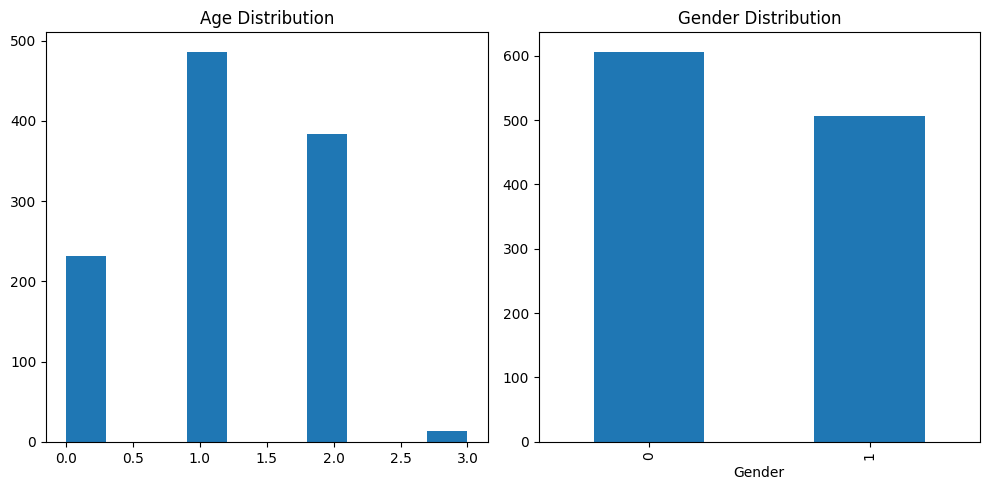

Correlations with CogFluidComp_Unadj:
Age                  -0.156006
Gender                0.063540
CogFluidComp_Unadj    1.000000
Name: CogFluidComp_Unadj, dtype: float64


In [12]:
print(data[['Age', 'Gender']].describe())

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(data['Age'])
plt.title('Age Distribution')
plt.subplot(122)
data['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

print("Correlations with CogFluidComp_Unadj:")
print(data[['Age', 'Gender', 'CogFluidComp_Unadj']].corr()['CogFluidComp_Unadj'])

In [13]:
print("Parents of CogFluidComp_Unadj:", model.network.get_parents('CogFluidComp_Unadj'))

Parents of CogFluidComp_Unadj: ['Age', 'MMSE_Score', 'FS_L_Hippo_Vol', 'FS_Tot_WM_Vol', 'NEOFAC_C', 'FS_Total_GM_Vol', 'FS_R_Hippo_Vol', 'Gender', 'ProcSpeed_Unadj', 'CardSort_Unadj']
